In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')

main_dataset = pd.read_excel("./buffer/1-main_dataset.xlsx")
main_dataset.drop(columns=main_dataset.columns[0], axis=1, inplace=True)

In [37]:
X = main_dataset.drop(columns="Attrition", axis=1)
y = [i == "Yes" for i in main_dataset["Attrition"]]

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,  random_state=0)

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

model_dict = {
    'Random Forest': RandomForestClassifier(random_state=0),
    'Logistic Regression': LogisticRegression(C=0.15, penalty="l2"),
    'Multi Layered Perceptron': MLPClassifier(random_state=0)
}

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
      ('imputer', SimpleImputer(strategy='median')),
      ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
      ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
      ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
      transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

full_pipeline_dict = {}
for name, model in model_dict.items():
      full_pipeline_dict[name] = Pipeline(steps=[
            ('preprocessor', preprocessor),
            (name, model)])

In [40]:
for name, pipeline in full_pipeline_dict.items():
    pipeline.fit(X_train, y_train)
    score = pipeline.score(X_test, y_test)
    print(f"{name} score: {score}")

Random Forest score: 0.9852607709750567
Logistic Regression score: 0.8503401360544217
Multi Layered Perceptron score: 0.9897959183673469


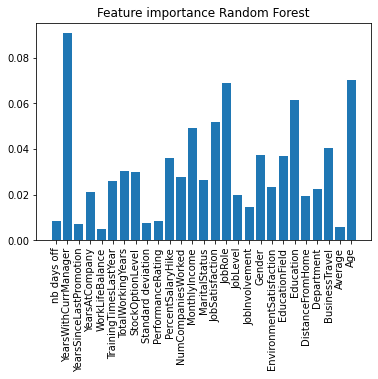

In [54]:
feature_importance = model_dict['Random Forest'].feature_importances_
feature_importance = {X_train.columns[i]: feature_importance[i] for i in range(len(X_train.columns))}
feature_importance = dict(sorted(feature_importance.items(), reverse=True))

graph_l = feature_importance.keys()
y_pos = np.arange(len(graph_l))
graph_x = feature_importance.values()

#ax = axs[i].add_axes([0,0,1,1])
plt.bar(y_pos, graph_x)
plt.xticks(y_pos, labels=graph_l, rotation=90)
plt.title('Feature importance Random Forest')

plt.show()

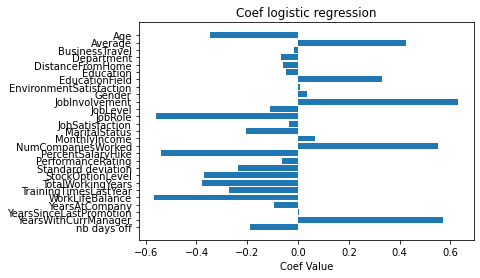

In [65]:
feature_importance = model_dict['Logistic Regression'].coef_[0]
feature_importance = {X_train.columns[i]: feature_importance[i] for i in range(len(X_train.columns))}
feature_importance = dict(sorted(feature_importance.items(), reverse=True))

graph_l = feature_importance.keys()
y_pos = np.arange(len(graph_l))
graph_x = feature_importance.values()

plt.barh(y_pos, graph_x)
plt.yticks(y_pos, labels=graph_l)
plt.xlabel('Coef Value')
plt.title('Coef logistic regression')

plt.show()

# Calule des variations

In [55]:
def variation(model: RandomForestClassifier, X: pd.DataFrame, y, param: str):
    if param not in X.columns:
        return
    
    # Copy of the datasets for translating the values
    X_p = X.copy()
    X_m = X.copy()

    # Finding the translation amount
    maxi = max(X[param])
    mini = min(X[param])
    alpha = ( maxi - mini ) / 5

    # Translating the parameter
    X_p[param] += np.array([alpha]*len(X[param]))
    X_m[param] -= np.array([alpha]*len(X[param]))

    # Get the prediciton with the new model
    y_p_predicted = model.predict(X_p)
    y_m_predicted = model.predict(X_m)
    y_predicted = model.predict(X)

    # Get the scores
    y_score = sum(y_predicted)
    y_p_score = sum(y_p_predicted)
    y_m_score = sum(y_m_predicted)

    return (
        y_score - y_p_score,
        y_score - y_m_score
    )

In [56]:
dict_var = {}
for column in X_test.columns:
    if column in numeric_features:
        dict_var[column] = variation(full_pipeline_dict["Multi Layered Perceptron"], X_test, y_test, column)

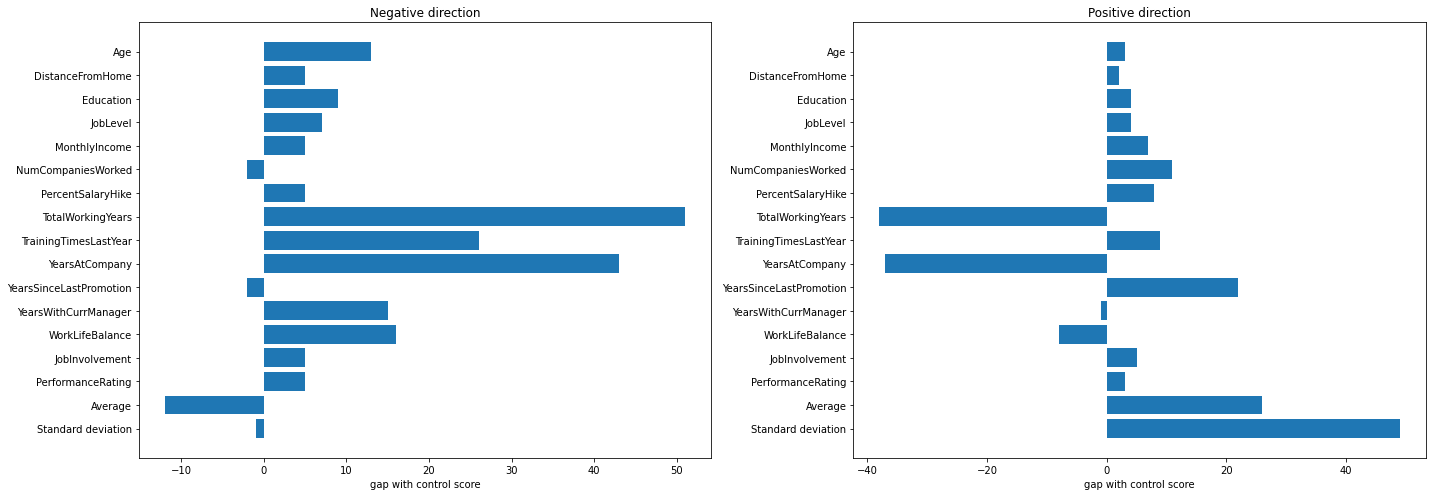

In [57]:
dict_var = {k: v for k, v in dict_var.items() if v[0] != 0 and v[1] != 0}
graph_l = dict_var.keys()
y_pos = np.arange(len(graph_l))

fig, axs = plt.subplots(1, 2, figsize=(20, 7))

for i in range(len(axs)):
    graph_x = [j[i] for j in dict_var.values()]
    #ax = axs[i].add_axes([0,0,1,1])
    axs[i].barh(y_pos, graph_x)
    axs[i].set_yticks(y_pos, labels=graph_l)
    axs[i].invert_yaxis()
    axs[i].set_xlabel('gap with control score')
    axs[i].set_title('Negative direction' if i == 0 else 'Positive direction')

fig.tight_layout()
plt.show()

In [59]:
{k: v for k, v in dict_var.items() if v[0] != 0 and v[1] != 0 }

{'Age': (13, 3),
 'DistanceFromHome': (5, 2),
 'Education': (9, 4),
 'JobLevel': (7, 4),
 'MonthlyIncome': (5, 7),
 'NumCompaniesWorked': (-2, 11),
 'PercentSalaryHike': (5, 8),
 'TotalWorkingYears': (51, -38),
 'TrainingTimesLastYear': (26, 9),
 'YearsAtCompany': (43, -37),
 'YearsSinceLastPromotion': (-2, 22),
 'YearsWithCurrManager': (15, -1),
 'WorkLifeBalance': (16, -8),
 'JobInvolvement': (5, 5),
 'PerformanceRating': (5, 3),
 'Average': (-12, 26),
 'Standard deviation': (-1, 49)}